In [1]:
import numpy as np
from utils import *
from map import OccupancyMap
from transform import *
import matplotlib.pyplot as plt
from motion import *
from observation import *
from particle import *

In [2]:
dataset = 20
root = "../data/"
joint_data, range_lim, lidar_angle_lim = GetData(root, dataset)

In [3]:
# plot map with first laser scan
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
xlim = (-30,30)
ylim = (-30,30)
T = Transform(range_lim, lidar_angle_lim)
Map = OccupancyMap(T, xlim=xlim, ylim=ylim, res=0.2)

In [4]:
# dead-reckoning
robot_pose = GetOdometry(joint_data)

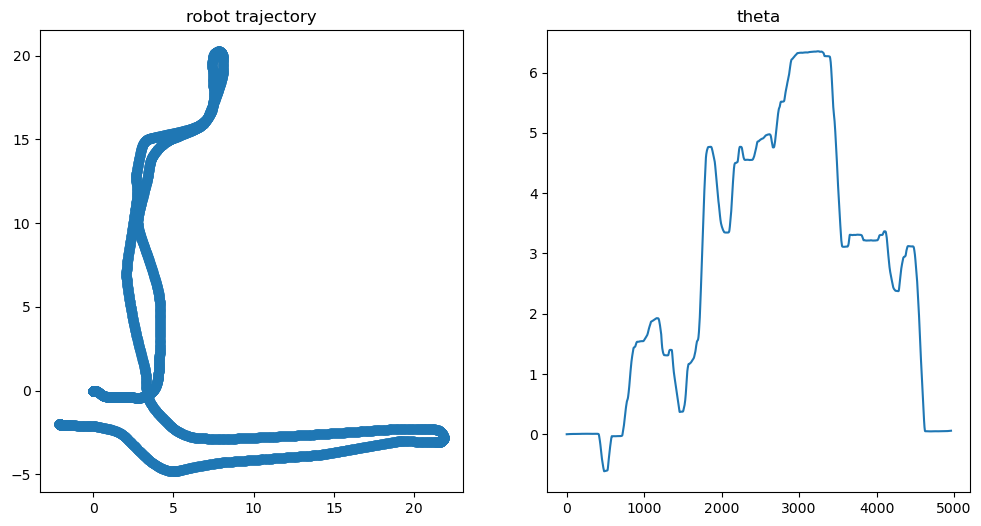

In [5]:
# plot trajectory
traj = robot_pose[:,:2]
theta = robot_pose[:, 2]

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
plt.scatter(traj[:,0], traj[:,1])
plt.title("robot trajectory")

ax2 = fig.add_subplot(122)
plt.plot(theta)
plt.title("theta")
plt.show()

Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200
Step 1300
Step 1400
Step 1500
Step 1600
Step 1700
Step 1800
Step 1900
Step 2000
Step 2100


/Users/lintsao/Desktop/UCSD/ECE 276A/Particle-Filter-SLAM/src/map.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6,6))


Step 2200
Step 2300
Step 2400
Step 2500
Step 2600
Step 2700
Step 2800
Step 2900
Step 3000
Step 3100
Step 3200
Step 3300
Step 3400
Step 3500
Step 3600
Step 3700
Step 3800
Step 3900
Step 4000
Step 4100
Step 4200
Step 4300
Step 4400
Step 4500
Step 4600
Step 4700
Step 4800
Step 4900


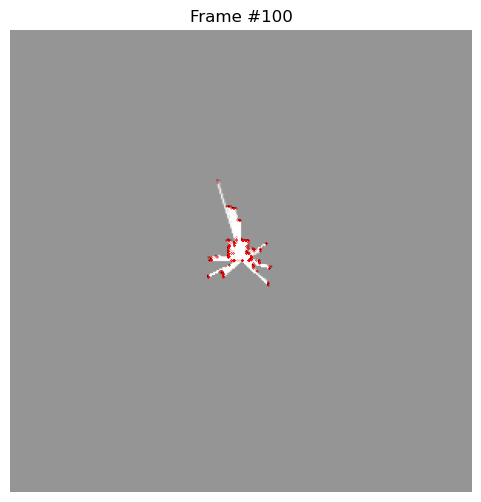

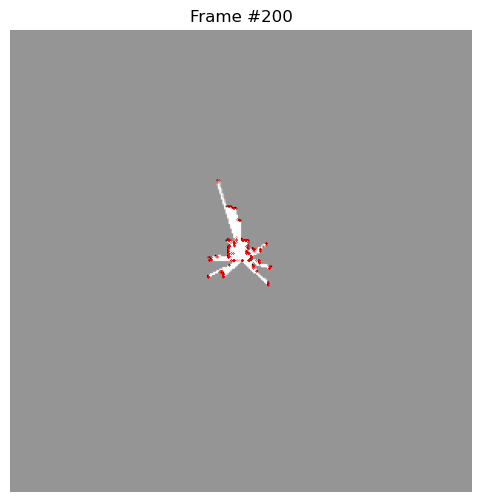

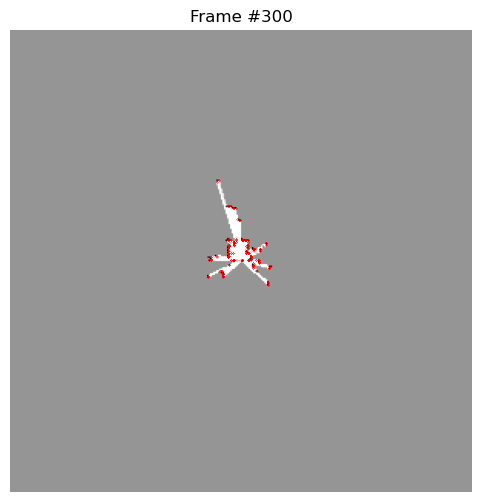

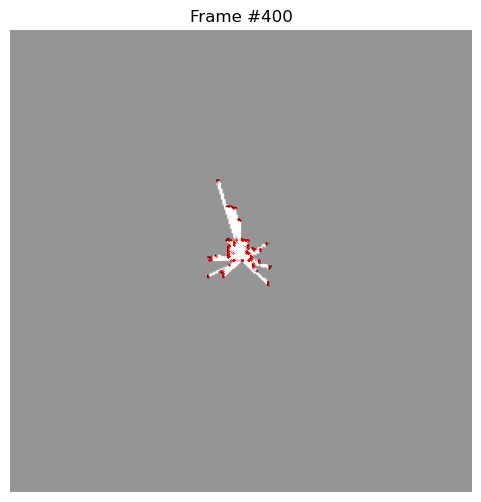

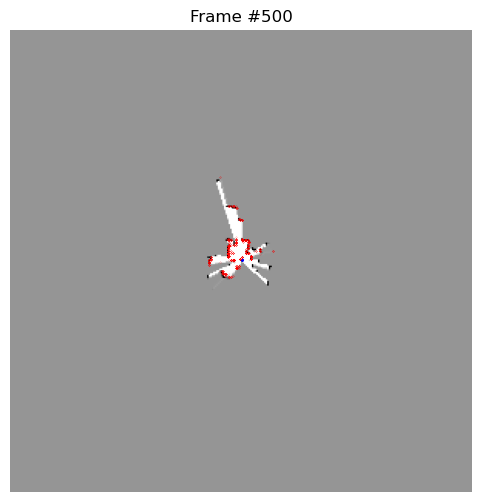

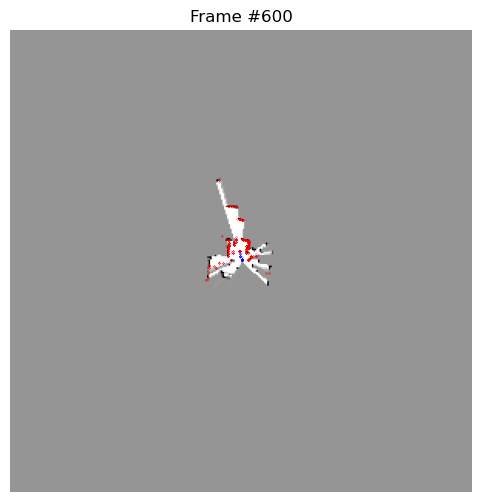

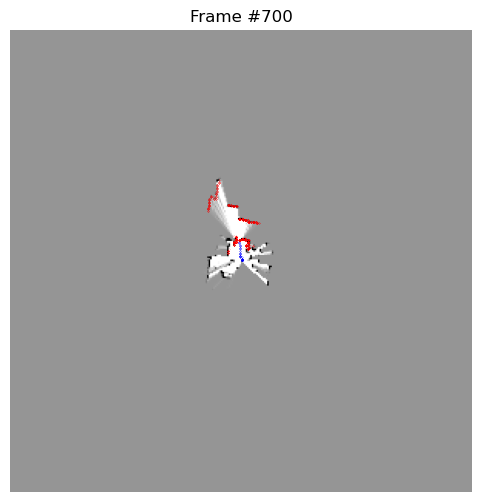

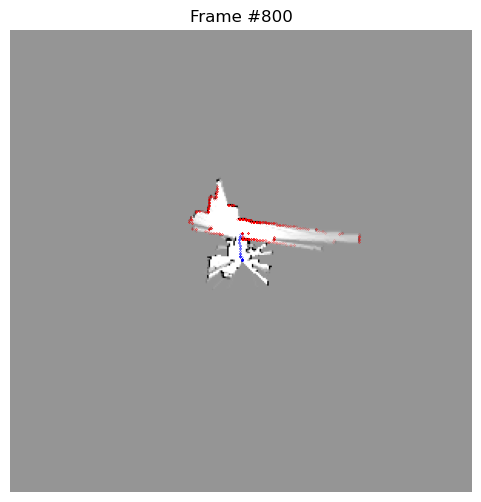

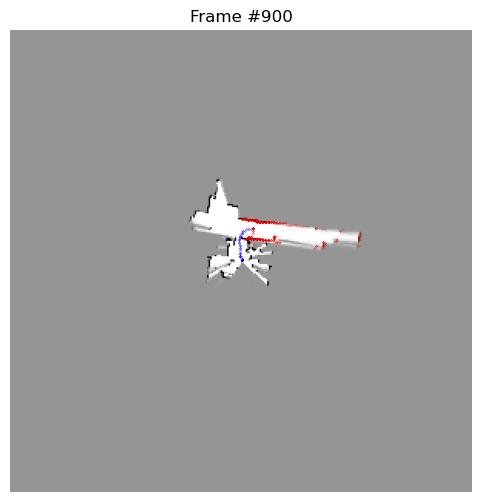

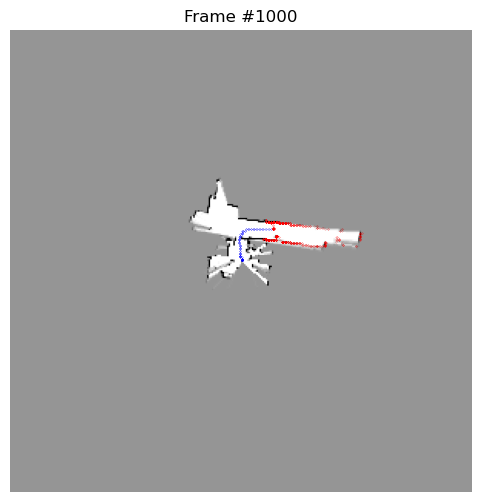

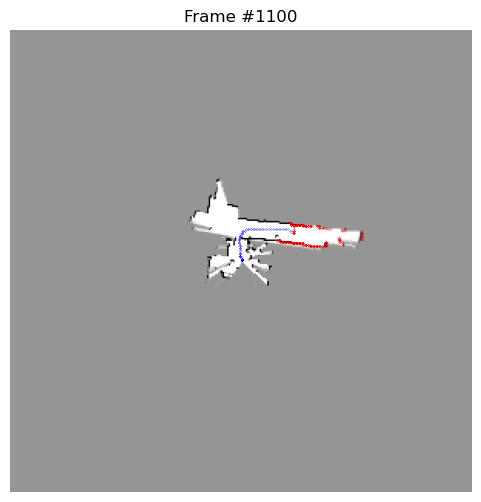

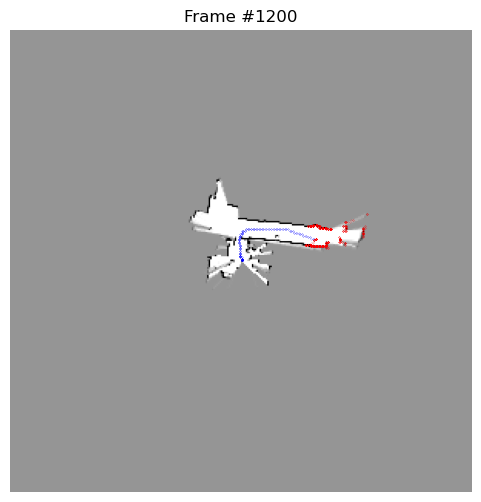

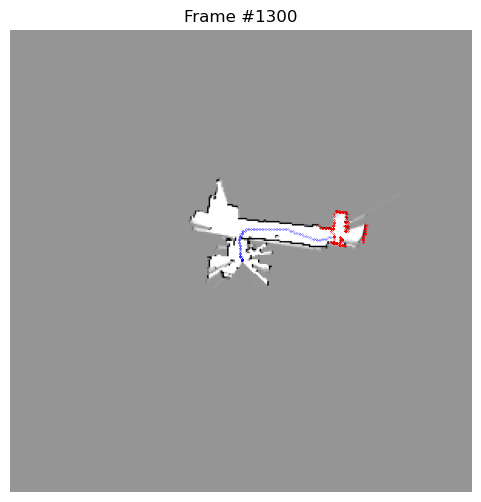

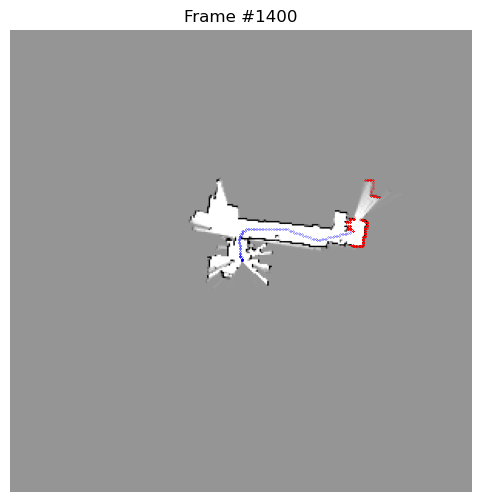

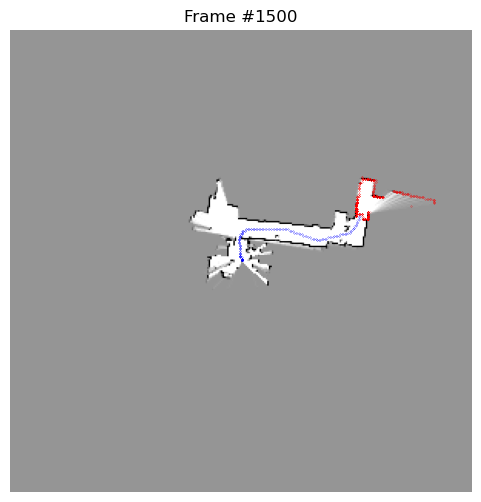

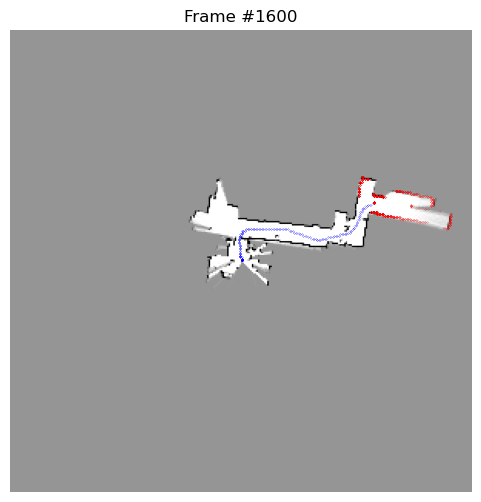

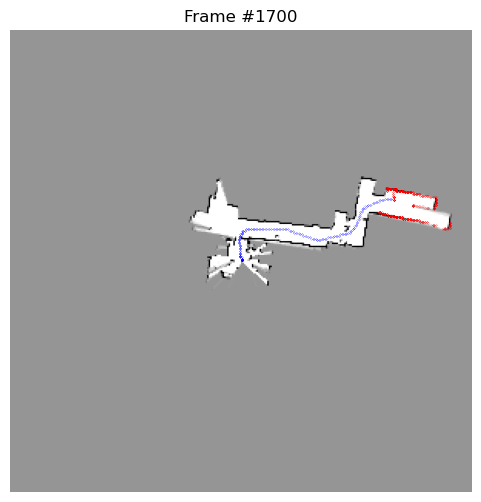

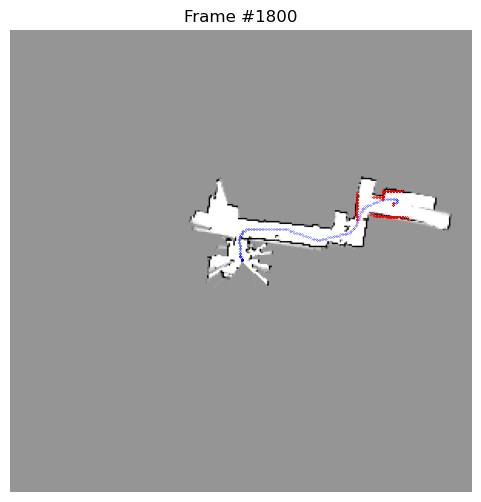

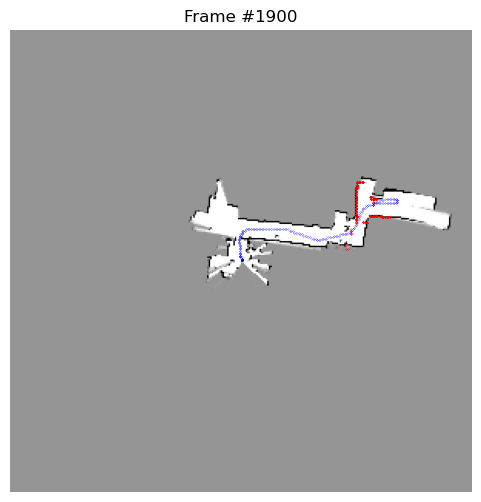

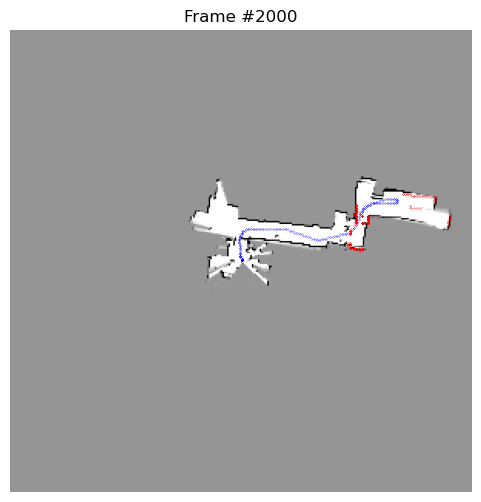

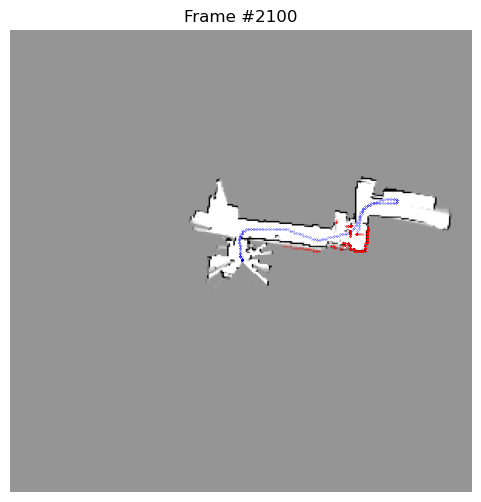

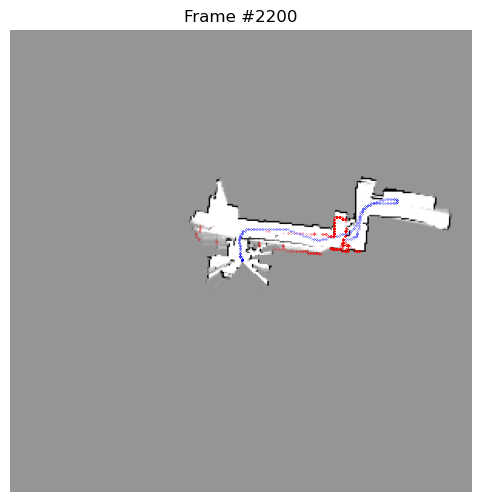

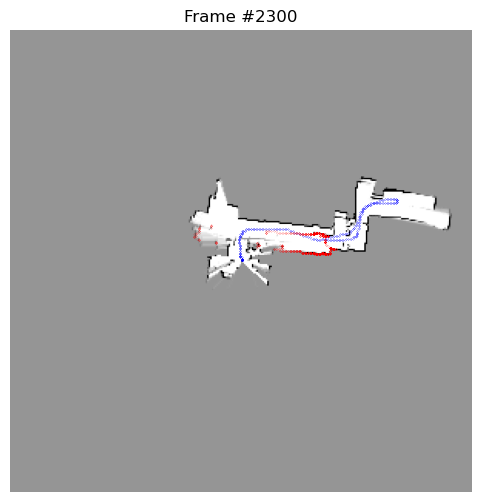

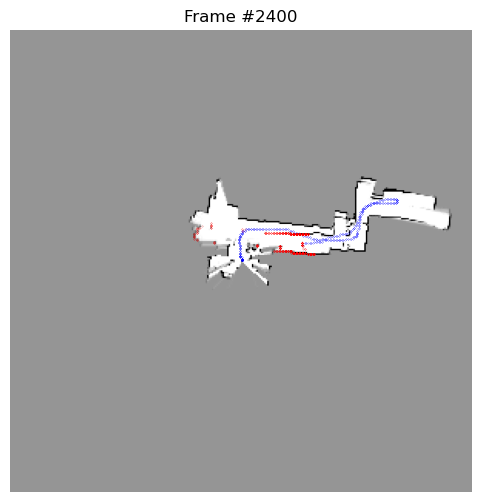

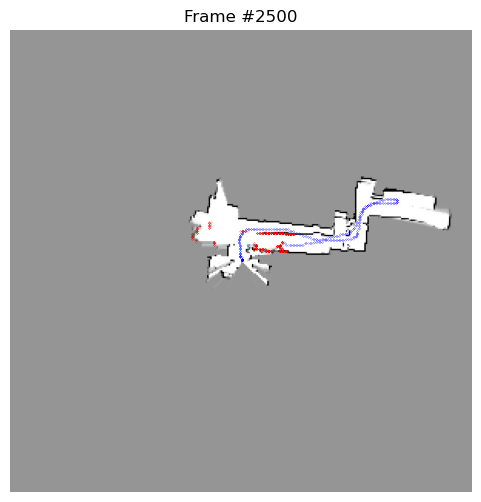

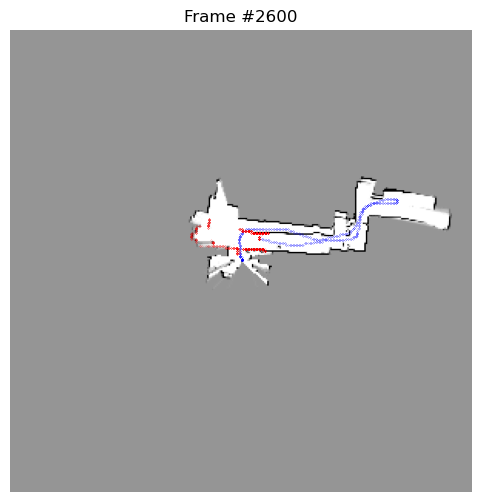

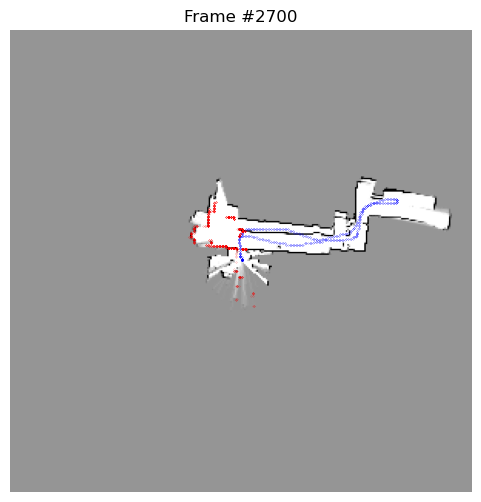

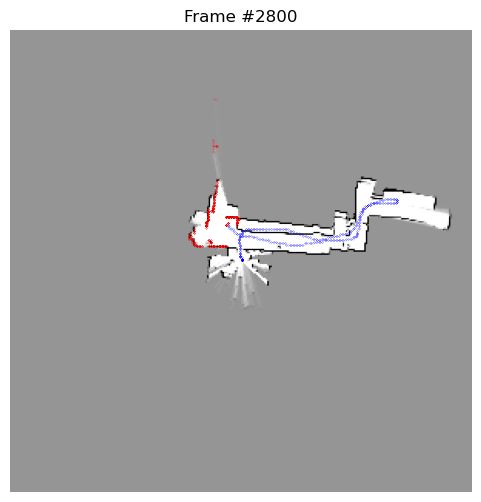

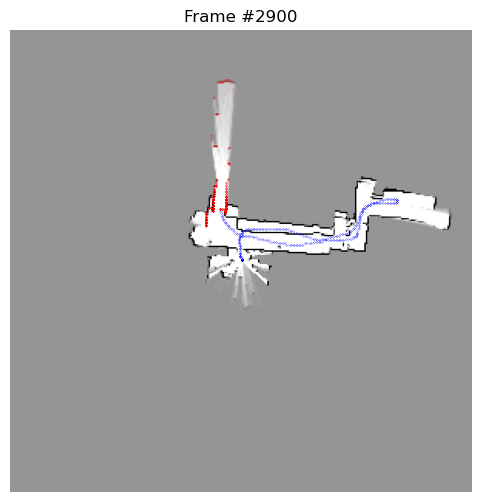

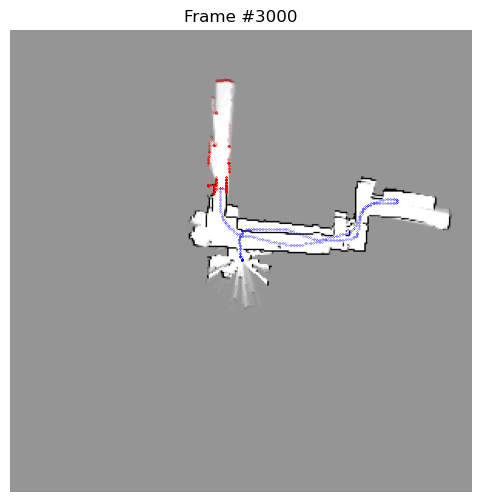

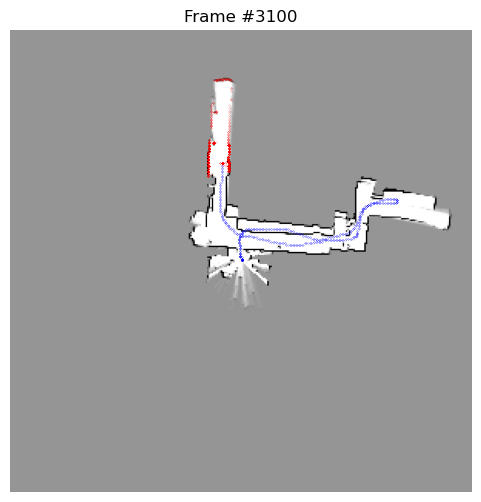

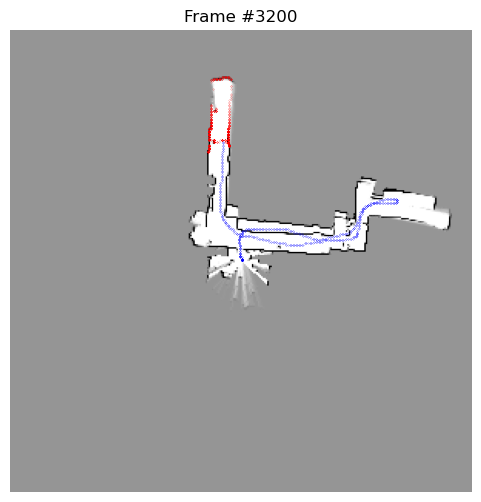

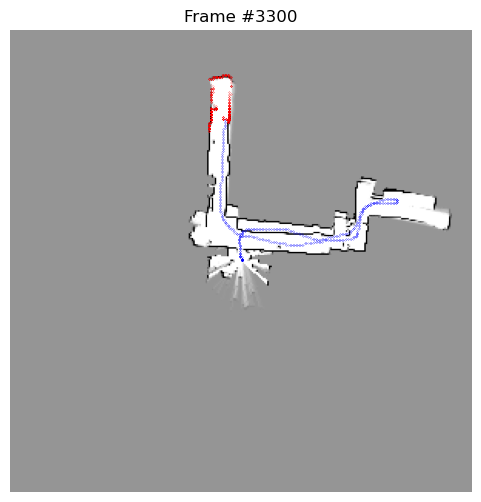

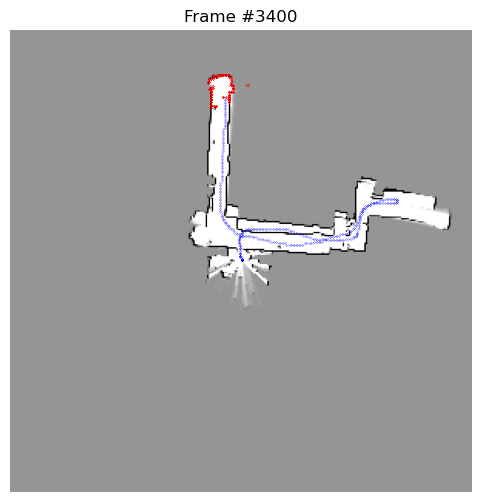

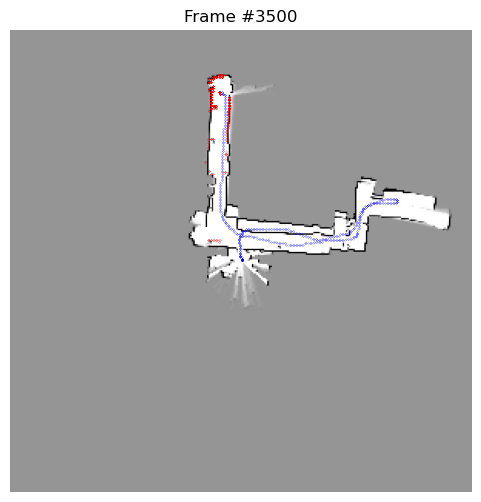

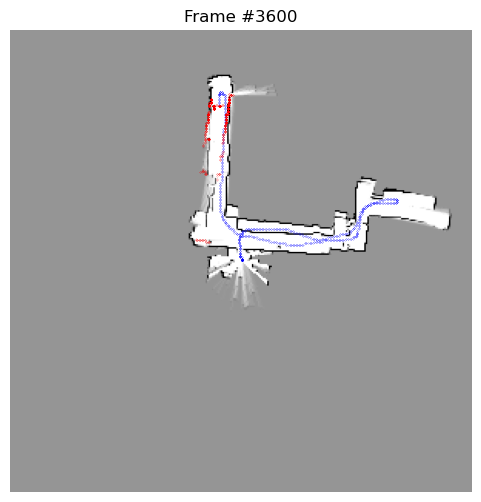

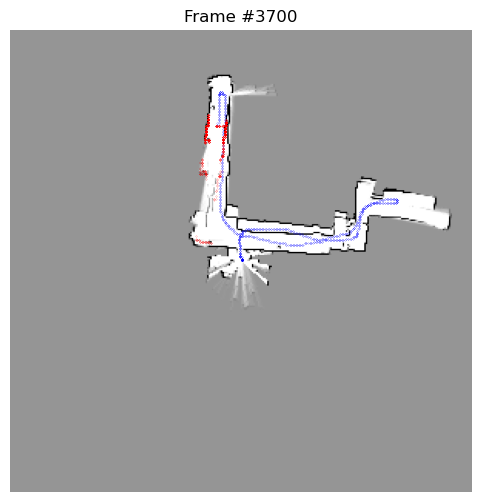

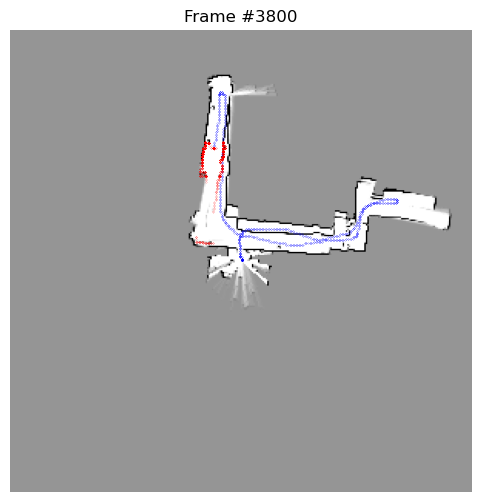

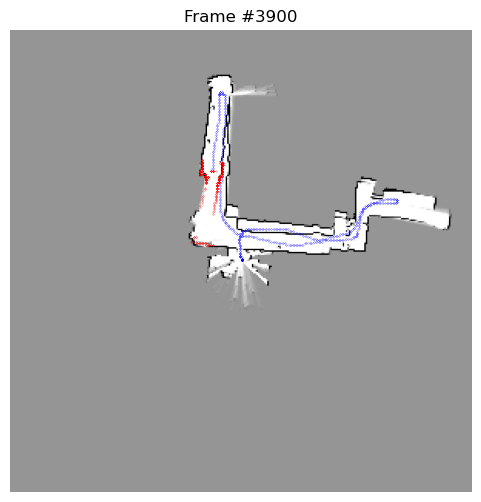

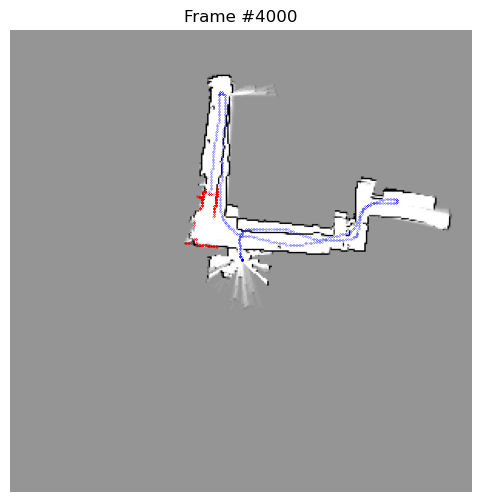

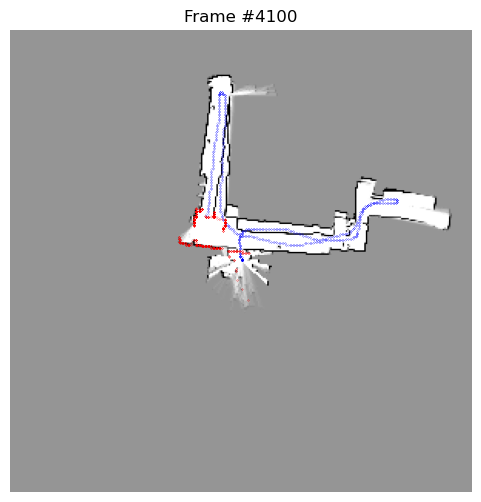

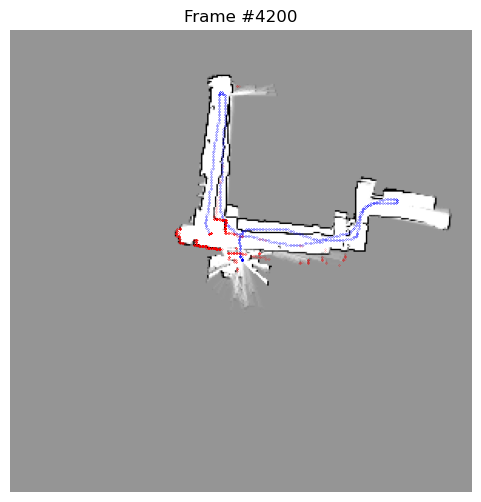

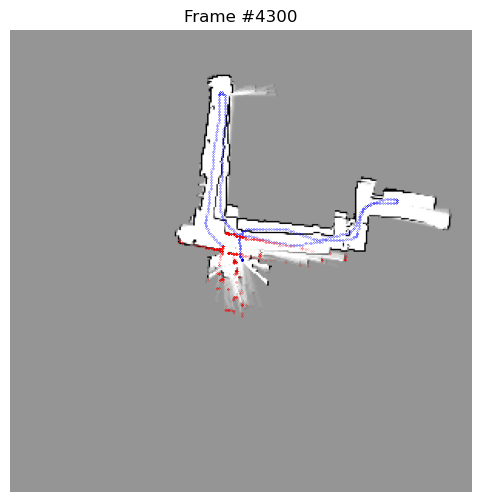

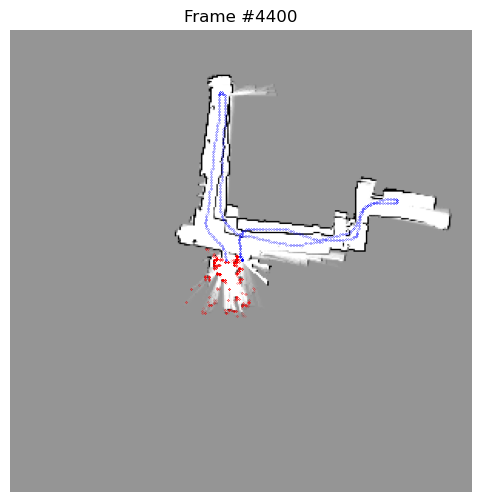

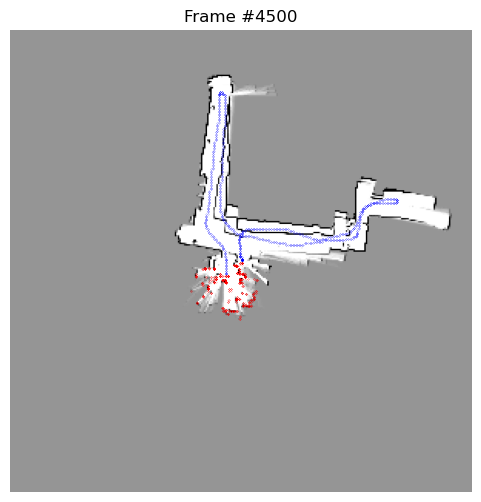

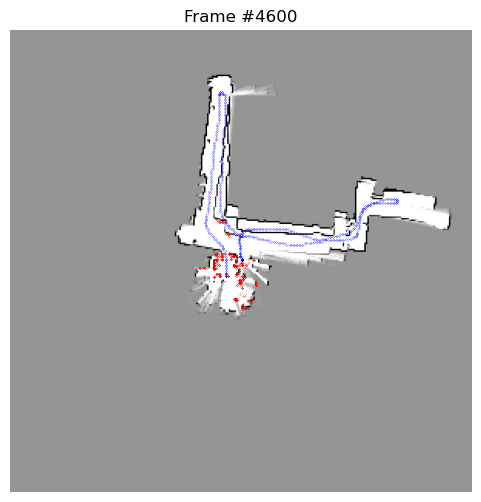

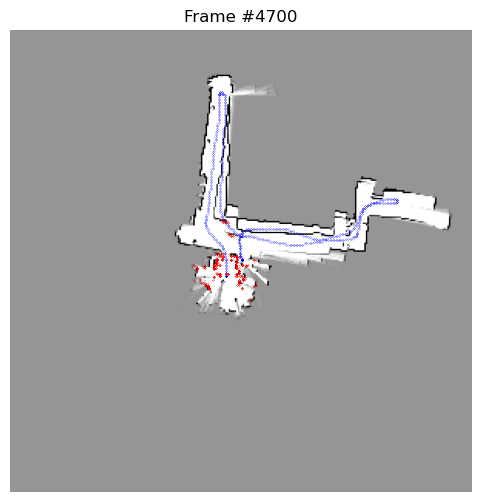

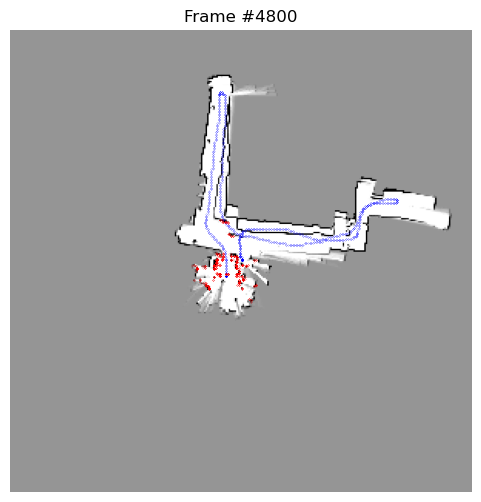

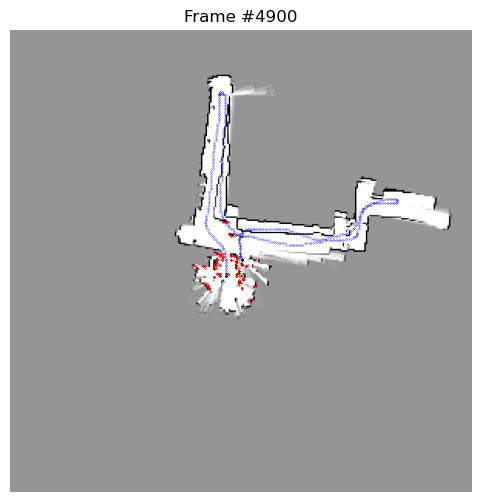

In [6]:
# with only deadreckoning
trajectory_dead = np.empty(shape=(1,2))
step_size = 4
for i in range(0, len(joint_data), step_size):
    if i == 0:
        continue

    data = joint_data[i]

    # Predict, get pose
    cur_pose = robot_pose[i]

    # No update
    trajectory_dead = np.vstack((trajectory_dead, [int(cur_pose[0] / Map.res) + Map.xsize // 2, int(cur_pose[1] / Map.res) + Map.ysize // 2]))

    # Mapping
    best_pose = { 'x': cur_pose[0], 'y': cur_pose[1], 'theta': cur_pose[2]}
    Map.mapping(data['lidar_ranges'], best_pose)

    if i % 100 == 0:
        print(f"Step {i}")
        Map.plot(trajectory_dead, data, best_pose, f"../frames_{dataset}_dead/frame_{i}.png", i)

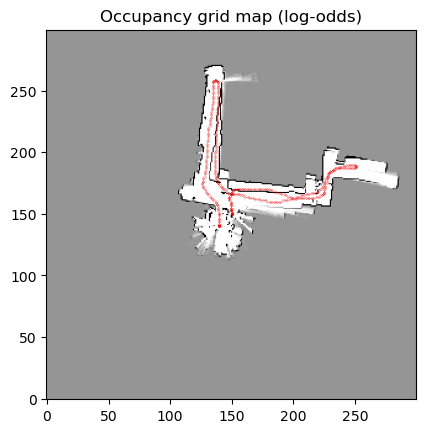

In [7]:
plt.imshow(Map.grid, cmap='Greys', origin='lower')
plt.scatter(trajectory_dead[1:].T[1], trajectory_dead[1:].T[0], s=0.05, c='r', marker='.')
plt.title("Occupancy grid map (log-odds)")
plt.savefig(f"{dataset}.png", bbox_inches='tight')

In [8]:
GetGif(f"../frames_{dataset}_dead/", f"test_dead_{dataset}.gif")

Plot...


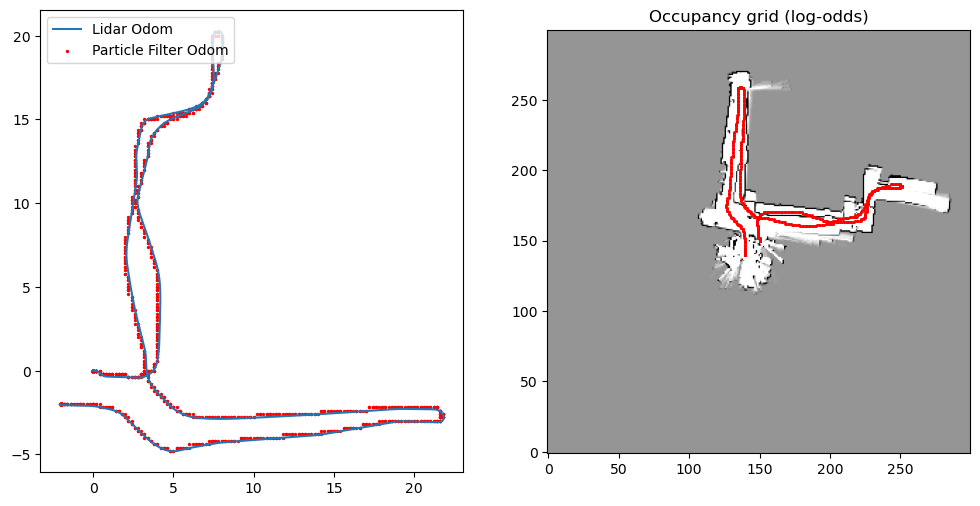

In [9]:
print("Plot...")
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
plt.plot(robot_pose.T[0], robot_pose.T[1], label="Lidar Odom")
plt.scatter((trajectory_dead[1:].T[0] - Map.grid.shape[0] // 2) * Map.res,
            (trajectory_dead[1:].T[1] - Map.grid.shape[1] // 2) * Map.res,
            label="Particle Filter Odom", s=2, c='r')
plt.legend(loc='upper left')

ax2 = fig.add_subplot(122)
# plt.imshow(self.grid, cmap='gray', vmin=-100, vmax=100, origin='lower')
plt.imshow(Map.grid, cmap='Greys', origin='lower')
plt.scatter(trajectory_dead[1:].T[1], trajectory_dead[1:].T[0], s=1, c='r')
plt.title("Occupancy grid (log-odds)")
plt.show()

In [10]:
# use particle filter
# plot map with first laser scan
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
xlim = (-30,30)
ylim = (-30,30)
T = Transform(range_lim, lidar_angle_lim)
Map = OccupancyMap(T, xlim=xlim, ylim=ylim, res=0.2)

num_particle = 200
P = Particle(num=num_particle)
x_sigma = 1e-4 * 5
y_sigma = 1e-4 * 5
omega_sigma = 1e-5 * 1
noise_var_scale = np.diag([x_sigma, y_sigma, omega_sigma])
trajectory = np.empty(shape=(1,2))

In [11]:
step_size = 4
for i in range(0, len(joint_data), step_size):
    if i == 0:
        continue

    data = joint_data[i]

    # Predict
    delta_pose = GetRelativeMotion(robot_pose, i, step_size)
    P.state = MotionModelPrediction(P.state , delta_pose, noise_var_scale)

    # Update
    best_particle = UpdateParticle(Map, P, data['lidar_ranges'], T)
    trajectory = np.vstack((trajectory, [int(best_particle[0] / Map.res) + Map.xsize // 2, int(best_particle[1] / Map.res) + Map.ysize // 2]))

    # Mapping
    best_pose = { 'x': best_particle[0], 'y': best_particle[1], 'theta': best_particle[2] }
    Map.mapping(data['lidar_ranges'], best_pose)

    # Resample
    N_eff = 1 / np.sum(P.weight ** 2)
    if N_eff < 0.1 * P.num:
        print("Resampling...")
        P.resampling()
    
    if i % 100 == 0:
        print(f"Step {i}")
        Map.plot(trajectory, data, best_pose, f"../frames_{dataset}/frame_{i}.png", i)

Step 100
Step 200
Step 300
Step 400
Step 500


/var/folders/8h/fmr63tyn6y52bw5l9rj4pby80000gn/T/ipykernel_90383/3466578843.py:24: RuntimeWarning: overflow encountered in scalar divide
  N_eff = 1 / np.sum(P.weight ** 2)
/var/folders/8h/fmr63tyn6y52bw5l9rj4pby80000gn/T/ipykernel_90383/3466578843.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  N_eff = 1 / np.sum(P.weight ** 2)


Step 600
Step 700
Step 800


In [ ]:
GetGif(f"../frames_{dataset}/", f"../gif/test_{dataset}.gif")

Plot...


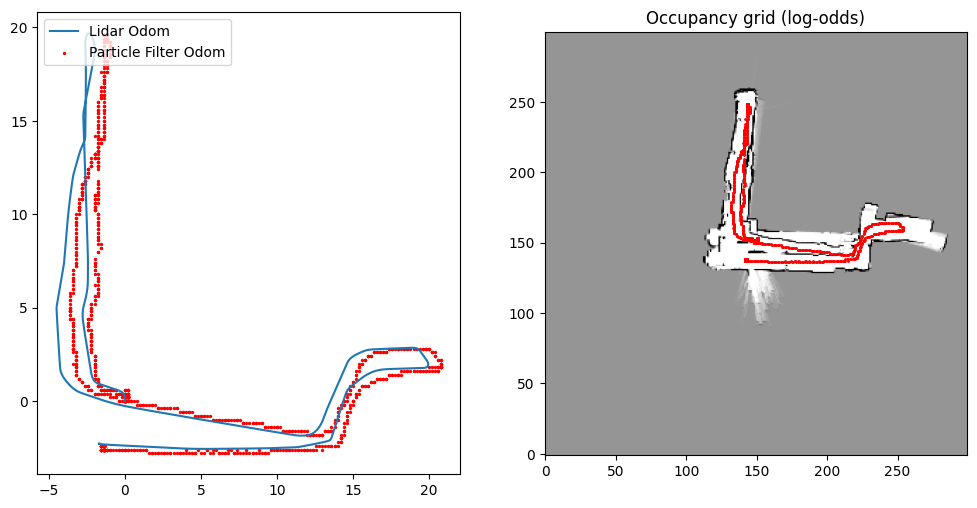

In [ ]:
print("Plot...")
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
plt.plot(robot_pose.T[1], robot_pose.T[0], label="Lidar Odom")
plt.scatter((trajectory[1:].T[1] - Map.grid.shape[1] // 2) * Map.res,
            (trajectory[1:].T[0] - Map.grid.shape[0] // 2) * Map.res,
            label="Particle Filter Odom", s=2, c='r')
plt.legend(loc='upper left')

ax2 = fig.add_subplot(122)
plt.imshow(Map.grid, cmap='Greys', origin='lower')
plt.scatter(trajectory[1:].T[1], trajectory[1:].T[0], s=1, c='r')
plt.title("Occupancy grid (log-odds)")
plt.show()